In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from tqdm.notebook import tqdm
from datetime import datetime
from random import choice
from glob import glob
## gmplot - dependency to create geoplot
import gmplot

In [2]:
files = glob("input/feed/bus_movements_2019_07_07.db")
db = sqlite3.connect(files[0])
speed_data = db.execute("Select speed, timestamp, route_id, trip_id, lat, lng from vehicle_feed")

In [3]:
to_radian = lambda x : x/57.29577951

def haversine_dist(lat1, lon1, lat2, lon2):
    lat1 = to_radian(lat1)
    lon = to_radian(lon1) - to_radian(lon2)
    lat2 = to_radian(lat2)
    a = np.sin((lat1-lat2) / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon / 2)**2
    c = 2*np.arcsin(np.sqrt(a))

    return 6373.0 * c * 1000

In [4]:
tree = {}
count = 0
for e in speed_data:
    if int(e[2]) not in tree:
        tree[int(e[2])]  = {}
    if e[3] not in tree[int(e[2])]:
        tree[int(e[2])][e[3]]  = {}
    
    if int(e[1]) not in tree[int(e[2])][e[3]]:
        tree[int(e[2])][e[3]][int(e[1])] = np.array([e[0], e[-2], e[-1]]).astype(float)

In [5]:
len(tree.keys())

444

In [6]:
stops_data = dict()
i = 0
for e in open("input/static/stops.txt").read().split("\n")[1:-1]:
    split = e.split(",")
    stops_data[int(split[0])] = (float(split[-2]), float(split[-1]), split[0], split[1], i)
    i+=1
# stops_data = np.array([e.split(",")[-2:] for e in  open("input/stops.txt").read().split("\n")[1:-1]]).astype(np.float32)

In [7]:
trips_data = dict()
for e in open("input/static/stop_times.txt").read().split("\n")[1:-1]:
    split = e.split(",")
    trip_id = split[0]
    if trip_id not in trips_data:
        trips_data[trip_id] = []
    trips_data[trip_id].append((int(split[3]), int(split[-1])))

In [8]:
routes_data = dict()
for e in open("input/static/trips.txt").read().split("\n")[1:-1]:
    split = e.split(",")
    route_id = int(split[0])
    trip_id = split[2]
    if route_id not in routes_data:
        routes_data[route_id] = np.array(sorted(trips_data[trip_id], key=lambda e:e[1]))[:, 0]

In [9]:
stop_tree = {}
for route_id in tree:
    stop_tree[route_id] = {}
    for trip_id in tree[route_id]:
        stop_tree[route_id][trip_id] = [None]*len(routes_data[route_id])

        time_stamps = sorted(tree[route_id][trip_id].keys())
        stop_id = 0
        for each_click in time_stamps:
            prev_distance = haversine_dist(stops_data[routes_data[route_id][stop_id]][0], stops_data[routes_data[route_id][stop_id]][1],
                                           tree[route_id][trip_id][each_click][1], tree[route_id][trip_id][each_click][2])
            
            for each_stop in range(stop_id+1, len(routes_data[route_id])):
                cur_distance = haversine_dist(stops_data[routes_data[route_id][each_stop]][0], stops_data[routes_data[route_id][each_stop]][1],
                                              tree[route_id][trip_id][each_click][1], tree[route_id][trip_id][each_click][2])
                if cur_distance < prev_distance:
                    prev_distance = cur_distance
                    stop_id = each_stop
                else:
                    break
            
            if prev_distance < 150:
                if stop_tree[route_id][trip_id][stop_id] == None:
                    stop_tree[route_id][trip_id][stop_id] = []
                stop_tree[route_id][trip_id][stop_id].append((each_click, prev_distance, cur_distance))

In [10]:
len(stop_tree)

444

In [89]:
# cd = []
# trip_id = "12313"
# time_stamps = sorted(tree[route_id][trip_id].keys())
# for each_click in time_stamps:
#     cd.append(tree[route_id][trip_id][each_click][1:])
# cd = np.array(cd)

gmap3 = gmplot.GoogleMapPlotter(lat = stops_data[routes_data[426][0]][0], lng = stops_data[routes_data[426][0]][1], zoom=15)

points = stop_tree[426]['12298'][0]
gmap3.marker(stops_data[routes_data[426][0]][0], stops_data[routes_data[426][0]][1], color="green",
        title="time spend : {} seconds, initial distance : {}, final distance: {}, final difference : {}".format(
                    (points[-1][0] - points[0][0]), np.round(points[0][1], 2),
                    np.round(points[-1][1], 2), np.round(points[-1][2], 2)))

for e in range(1, len(routes_data[426])-1):
    points = stop_tree[426]['12298'][e]
    if points is not None:
        gmap3.marker(stops_data[routes_data[426][e]][0], stops_data[routes_data[426][e]][1], color="blue",
            title="time spend : {} seconds, initial distance : {}, final distance: {}, final difference : {}".format(
                        (points[-1][0] - points[0][0]), np.round(points[0][1], 2),
                        np.round(points[-1][1], 2), np.round(points[-1][2], 2)))
    else:
        gmap3.marker(stops_data[routes_data[426][e]][0], stops_data[routes_data[426][e]][1], color="pink",
                    title="Not found")

points = stop_tree[426]['12298'][-1]

if points is not None:
    gmap3.marker(stops_data[routes_data[426][-1]][0], stops_data[routes_data[426][-1]][1], color="red",
            title="time spend : {} seconds, initial distance : {}, final distance: {}, final difference : {}".format(
                        (points[-1][0] - points[0][0]), np.round(points[0][1], 2),
                        np.round(points[-1][1], 2), np.round(points[-1][2], 2)))
else:
    gmap3.marker(stops_data[routes_data[426][-1]][0], stops_data[routes_data[426][-1]][1], color="yellow",
                    title="Not found")



gmap3.draw( "output/map.html" )

KeyError: 426

In [25]:

start_date = 1562437800

In [29]:
dictionary = {}
count = 0
for route_id in tree.keys():
    for s1 in routes_data[route_id]:
        if s1 not in dictionary:
            dictionary[s1] = count
            count += 1

In [39]:
matrix = np.zeros([len(dictionary), 144]).astype(np.float32)
count = np.zeros([len(dictionary), 144]).astype(np.float32)
for route_id in stop_tree:
    stops = routes_data[route_id]
    for each_trip in stop_tree[route_id]:

        for start_stop in range(len(stops)-1):
            if stop_tree[route_id][each_trip][start_stop] == None or stop_tree[route_id][each_trip][start_stop+1] == None:
                continue
            start_time = ((stop_tree[route_id][each_trip][start_stop][0][0] 
                            +stop_tree[route_id][each_trip][start_stop][-1][0])//2
                          - start_date)
            if start_time < 0:
                continue
            
            end_time = ((stop_tree[route_id][each_trip][start_stop+1][0][0] 
                            +stop_tree[route_id][each_trip][start_stop+1][-1][0])//2
                          - start_date)
            
            if (end_time - start_time) > 1800:
                continue

            matrix[dictionary[stops[start_stop]], start_time//600] += float(end_time - start_time)/60
            count[dictionary[stops[start_stop]], start_time//600] += 1

matrix /= count
matrix[np.isnan(matrix)] = 0

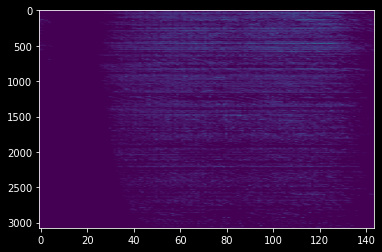

In [40]:
plt.imshow(matrix, aspect="auto", vmax=10)

In [12]:
dictionary = dict()
count = 0
for route_id in tree.keys():
    for s1_index in range(len(routes_data[route_id])):
        s1 = routes_data[route_id][s1_index]
        for s2 in routes_data[route_id][s1_index+1:]:
            if s1*534+s2 not in dictionary:
                dictionary[s1*534+s2] = count
                count += 1 

In [14]:
matrix = np.zeros([len(dictionary), 144]).astype(np.float32)
count = np.zeros([len(dictionary), 144]).astype(np.float32)
for route_id in stop_tree:
    stops = routes_data[route_id]
    for each_trip in stop_tree[route_id]:

        for start_stop in range(len(stops)):
            if stop_tree[route_id][each_trip][start_stop] == None or stop_tree[route_id][each_trip][start_stop+1] == None:
                continue
            start_time = ((stop_tree[route_id][each_trip][start_stop][0][0] 
                            +stop_tree[route_id][each_trip][start_stop][-1][0])//2
                          - start_date)
            if start_time < 0:
                continue

            for end_stop in range(start_stop+1, len(stops)):
                end_time = ((stop_tree[route_id][each_trip][start_stop+1][0][0] 
                                +stop_tree[route_id][each_trip][start_stop+1][-1][0])//2
                            - start_date)

                if end_time < 0:
                    raise ValueError("End time can not be negative")
                    
                
                if (end_time - start_time) > 1000 and (end_stop == start_stop+1):
                    break

                matrix[dictionary[stops[start_stop]*534 + stops[end_stop]], start_time//600] += float(end_time - start_time)/60
                count[dictionary[stops[start_stop]*534 + stops[end_stop]], start_time//600] += 1

matrix /= count
matrix[np.isnan(matrix)] = 0

NameError: name 'start_date' is not defined

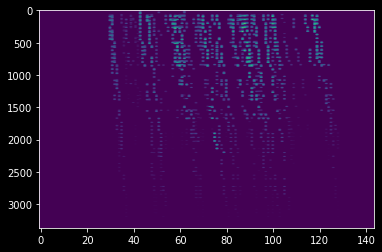

In [185]:
plt.imshow(matrix, aspect="auto")

In [42]:
np.savez_compressed(file="./output/matrix_complete_routes".format(route_id), matrix = matrix, route_id = route_id, stops = routes_data[route_id], map=dictionary)

In [154]:
matrix.shape

(3364, 144)

In [110]:
stop_tree[route_id].keys()

dict_keys(['12334', '12335', '12336', '12337', '12338', '12339', '12340', '12341', '12342', '12343', '12344', '12345', '12346', '12347', '12348', '12349', '12350', '12351', '12352', '12353', '12354', '12355', '12356', '12357', '12358', '12359', '12360', '12361', '12362', '12363', '12364', '12365', '12366', '12367', '12368', '12369', '12370', '12371', '12372', '12373', '12374', '12375', '12376', '12377', '12378', '12379', '12380', '12381', '12382', '12383', '12384', '12385', '12386', '12387', '12388', '12389', '12390', '12391', '12392'])

In [111]:
data = tree[route_id]["12334"]
keys = sorted(data.keys())
gmap3 = gmplot.GoogleMapPlotter(lat =data[keys[0]][1] , lng = data[keys[0]][2], zoom=15)

gmap3.marker(data[keys[0]][1], data[keys[0]][2], color="green", title=keys[0])
for e in keys[1:-1]:
    gmap3.marker(data[e][1], data[e][2], color="blue", title=e)

gmap3.marker(data[keys[-1]][1], data[keys[-1]][2], color="red", title=e)

for e in routes_data[route_id]:
    gmap3.marker(stops_data[e][0], stops_data[e][1], color="yellow")


gmap3.draw( "output/map.html" )

In [78]:
tree[route_id].keys()

dict_keys(['12313', '12315', '12312', '12310', '12314', '12265', '12266', '12267', '12268', '12269', '12270', '12271', '12272', '12273', '12274', '12275', '12276', '12277', '12278', '12279', '12280', '12281', '12282', '12283', '12284', '12285', '12286', '12287', '12288', '12289', '12290', '12291', '12292', '12293', '12294', '12295', '12296', '12297', '12298', '12299', '12300', '12301', '12302', '12303', '12304', '12305', '12306', '12307', '12308', '12309', '12311', '12316', '12317', '12318', '12319', '12320', '12321', '12322', '12323', '12324', '12325', '12326'])

In [29]:
total_routes = np.zeros(len(stops_data)*len(stops_data), dtype=bool)
for each_route in tqdm(routes_data.values()):
    for each_stop in each_route:
        for each_stop2 in each_route:
            total_routes[stops_data[each_stop][-1]*len(stops_data) + stops_data[each_stop2][-1]] = True

In [26]:
total_routes = np.zeros(len(stops_data)*len(stops_data), dtype=bool)
for each_stop in stops_data.values():
    for each_stop2 in stops_data.values():
        total_routes[each_stop[-1]*len(stops_data) + each_stop2[-1]] = True

In [31]:
np.count_nonzero(total_routes)

789893

In [11]:
stops_data[0]

(28.715917, 77.170867, '0', 'Adarsh Nagar / Bharola Village', 0)

In [130]:
 stop_tree[route_id][each_trip][start_stop][-1][0]

1562437792

In [101]:
len(stop_tree[426]['12312'])

54

In [89]:
stop_tree[426].keys()

dict_keys(['12313', '12315', '12312', '12310', '12314', '12265', '12266', '12267', '12268', '12269', '12270', '12271', '12272', '12273', '12274', '12275', '12276', '12277', '12278', '12279', '12280', '12281', '12282', '12283', '12284', '12285', '12286', '12287', '12288', '12289', '12290', '12291', '12292', '12293', '12294', '12295', '12296', '12297', '12298', '12299', '12300', '12301', '12302', '12303', '12304', '12305', '12306', '12307', '12308', '12309', '12311', '12316', '12317', '12318', '12319', '12320', '12321', '12322', '12323', '12324', '12325', '12326'])